### Test graphcut, 

#### Initial imports

In [1]:
import os
import glob
import sys

import shutil
import json

import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import nibabel as nib
from scipy.ndimage import morphology
import SimpleITK
import pandas as pd


gradient.shape:  (2, 256)
number of axes:  6
number of axes:  6


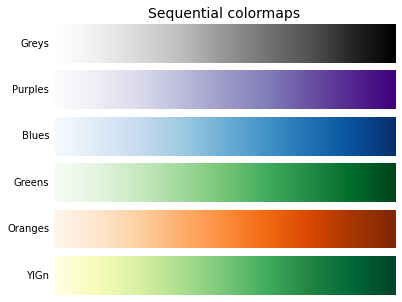

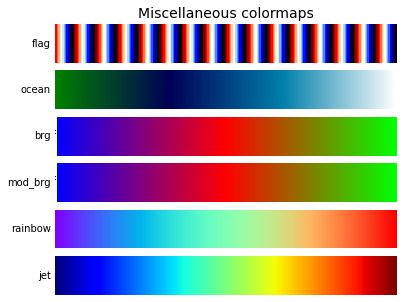

In [2]:
#Modified from https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict

cmaps = OrderedDict()
cmaps['Sequential'] = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'YlGn']
cmaps['Miscellaneous'] = ['flag',  'ocean', 'brg', 'mod_brg', 'rainbow', 'jet']
#cmaps.items()
# for cmap_category, cmap_list in cmaps.items():
#     print(cmap_category)
#     print(cmap_list)
nrows = max(len(cmap_list) for cmap_category, cmap_list in cmaps.items())
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
print('gradient.shape: ', gradient.shape)

def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows)
    print('number of axes: ', len(axes))
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        if name == 'mod_brg':
            #cmap=plt.get_cmap(name)
            cmap = plt.cm.get_cmap('brg')
            cmap._init()
            #print('lut shape :', colormap._lut.shape)
            #print('before setup:')
            #print(cmap._lut[0:10, :])
            cmap._lut[:1:,3]=0
            #print('after setup:')
            #print(cmap._lut[0:10, :])        
        else:
            #cmap=plt.get_cmap(name)
            cmap = plt.cm.get_cmap(name)
        ax.imshow(gradient, aspect='auto', cmap=cmap)
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()

for cmap_category, cmap_list in cmaps.items():
    plot_color_gradients(cmap_category, cmap_list, nrows)
plt.show() 




In [3]:
# some list - tuple generation, conversion
sliceId = 1
A = (4,10)
B = [sliceId]
C = tuple(B + list(A))
# print(A)
# print(B)
# print(C)

D = [(4, 1), (6, 6), (3, 5)]
E = [ tuple([sliceId] + list(tupleElem)) for  tupleElem in D]
#print(E)

F = np.zeros([2, 10, 10], dtype=np.uint8)
for coord in E : F[coord] = 1
#print(F)
print(max(10-3, 0))
print(min(126+4, 128))

7
128


In [4]:
ht = np.zeros((5,20,20), dtype=np.uint8)
ht[1, 4:11, 6:10]=1
ht[2, 7:17, 2:17]=1
ht[3, 3:10, 7:12]=1
print('Sum ', np.sum(ht))

fractionDivider = 2
misclassifiedRegion = np.zeros([2, 16, 16], dtype=np.uint8)
misclassifiedRegion[0, 5:7,5:7] = 1
misclassifiedRegion[1, 9, 10:12] = 1

onePixelsThisVol = np.where(misclassifiedRegion)
onePixelCoordsThisVol = list(zip(onePixelsThisVol[0], onePixelsThisVol[1], onePixelsThisVol[2]))
print(onePixelCoordsThisVol)
numOnePixelCoordsThisVol = len(onePixelCoordsThisVol)
#Debug:
print('numOnePixelCoordsThisVol ', numOnePixelCoordsThisVol)
numScribblesFromThisVol = numOnePixelCoordsThisVol // fractionDivider
chosenScribbleCoordsThisVol = random.sample(onePixelCoordsThisVol, numScribblesFromThisVol)
print(chosenScribbleCoordsThisVol)

#for coord in chosenScribbleCoordsThisVol : resultBinary[coord] = 1 

Sum  213
[(0, 5, 5), (0, 5, 6), (0, 6, 5), (0, 6, 6), (1, 9, 10), (1, 9, 11)]
numOnePixelCoordsThisVol  6
[(0, 5, 5), (1, 9, 11), (0, 6, 6)]


#### Important note about imcut (https://github.com/mjirik/imcut) seed: 0 = Unknown, 1 = FG, 2=BG; But in the segmentation result, 0 = FG and 1 = BG <-- This was not mentioned in the readme and it got me really confused for quite sometime

In [5]:
#Check basic 3D imcut APi; We will however use it as 2D
import imcut.pycut
im = np.random.random([1, 5, 5])
print('before: ')
print(im)
im[0, :3, :3] += 1.
print('after: ')
print(im)
#print('im.dtype ', im.dtype)

seeds = np.zeros([1, 5, 5], dtype=np.uint8)
seeds[0,:3,0] = 1
seeds[0,:3,4] = 2
print('seeds')
print(seeds)

gc = imcut.pycut.ImageGraphCut(im[0,...])
gc.set_seeds(seeds[0,...])
gc.run()

#print(gc.segmentation.squeeze())
print('segmentation shape, type: ', gc.segmentation.shape, gc.segmentation.dtype)
print('segmentation with 1 as FG')
print(1 - gc.segmentation)


before: 
[[[0.48369503 0.73874669 0.26167301 0.72239432 0.56322325]
  [0.43836962 0.83137636 0.24079001 0.66364851 0.06722126]
  [0.70521869 0.3521958  0.36508477 0.16559663 0.18034794]
  [0.46455936 0.03328442 0.86617766 0.92648889 0.32070017]
  [0.84487314 0.48940999 0.13710973 0.7901185  0.25568723]]]
after: 
[[[1.48369503 1.73874669 1.26167301 0.72239432 0.56322325]
  [1.43836962 1.83137636 1.24079001 0.66364851 0.06722126]
  [1.70521869 1.3521958  1.36508477 0.16559663 0.18034794]
  [0.46455936 0.03328442 0.86617766 0.92648889 0.32070017]
  [0.84487314 0.48940999 0.13710973 0.7901185  0.25568723]]]
seeds
[[[1 0 0 0 2]
  [1 0 0 0 2]
  [1 0 0 0 2]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
segmentation shape, type:  (5, 5) int8
segmentation with 1 as FG
[[1 1 1 0 0]
 [1 1 1 0 0]
 [1 1 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


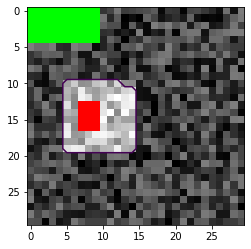

In [6]:
#More complex example without interactivity
import numpy as np
import imcut.pycut as pspc
import matplotlib.pyplot as plt

# create data
data = np.random.rand(5, 30, 30)
data[1:4, 10:20, 5:15] += 1
data = data * 30
data = data.astype(np.int16)
    
# Make seeds
seeds = np.zeros([5,30,30])
seeds[1:4, 13:17, 7:10] = 1
seeds[0:4, 0:5:, 0:10] = 2
    
# Run 
igc = pspc.ImageGraphCut(data, voxelsize=[1, 1, 1])
igc.set_seeds(seeds)
igc.run()
    
# Show results
colormap = plt.cm.get_cmap('brg')
colormap._init()
colormap._lut[:1:,3]=0
    
plt.imshow(data[3, :, :], cmap='gray') 
plt.contour(igc.segmentation[3,:, :], levels=[0.55])
plt.imshow(igc.seeds[3, :, :], cmap=colormap, interpolation='none')
plt.show()



In [7]:
sys.path.append('/home/user/DMML/CodeAndRepositories/MMGTVSeg')
import src
from src import scribbleHelper, gcHelper, graphCutClient, graphCutServer, libclient, libserver
from src.scribbleHelper import checkFolderExistenceAndCreate, readAndScaleImageData,\
    dice_coef_func, dice_multi_label, disk, ball, bbox2_3D, getUnionBoundingBoxWithPadding,\
    chooseScribbleFromMissedFGOrWrongCBG2D, chooseScribbleFromDefiniteRegion2D,\
    autoGenerateScribbleRegions2D,\
    chooseScribbleFromMissedFGOrWrongCBG3D, chooseScribbleFromDefiniteRegion3D,\
    autoGenerateScribbleAndBBox3D,\
    createGCInputUsingGT
# import src.gcHelper as gcHelper

In [8]:
#Test code
img = np.zeros((8,20,20), dtype=np.uint8)
img[1, 4:11, 6:10]=1
img[4, 7:14, 2:13]=1
img[5, 3:10, 7:12]=1

axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max =\
    bbox2_3D(img)
print(axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max)
axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max =\
    bbox2_3D(img, expandBBoxFlag=True, pad=1)
print(axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max)
axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max =\
    bbox2_3D(img, expandBBoxFlag=True, pad=4)
print(axial_min, axial_max, coronal_min, coronal_max, sagittal_min, sagittal_max)

1 5 3 13 2 12
0 6 2 14 1 13
0 7 0 17 0 16


In [9]:
gt = np.zeros((8,20,20), dtype=np.uint8)
gt[3, 6:11, 9:10]=1
gt[4, 7:13,10:13]=1
gt[5, 4:10, 11:19]=1
a_min_g, a_max_g, c_min_g, c_max_g, s_min_g, s_max_g = bbox2_3D(gt, expandBBoxFlag=False, pad=0)
print(a_min_g, a_max_g, c_min_g, c_max_g, s_min_g, s_max_g)

pred = np.zeros((8,20,20), dtype=np.uint8)
pred[4, 11:13, 5:15]=1
pred[5, 12:10, 7:12]=1
pred[6, 13:14, 6:10]=1 
a_min_p, a_max_p, c_min_p, c_max_p, s_min_p, s_max_p = bbox2_3D(pred, expandBBoxFlag=False, pad=0)
print(a_min_p, a_max_p, c_min_p, c_max_p, s_min_p, s_max_p)

#common with padding
bbPad=2
a_min, a_max, c_min, c_max, s_min, s_max = getUnionBoundingBoxWithPadding(gt, pred, bbPad)
print(a_min, a_max, c_min, c_max, s_min, s_max)
bbVolume = np.zeros_like(gt)
#Note the +1 without which we were notmaking the highest limit 1
bbVolume[a_min:a_max+1, c_min:c_max+1, s_min:s_max+1]=1
print(bbox2_3D(bbVolume, expandBBoxFlag=False, pad=0))

3 5 4 12 9 18
4 6 11 13 5 14
1 7 2 15 3 19
(1, 7, 2, 15, 3, 19)


In [10]:
# Test disk
G = np.zeros([16, 16], dtype=np.uint8)
G[5:13,4:7] = 1
dilated_G = scipy.ndimage.binary_dilation(G,structure=disk(2)).astype(G.dtype)

S = np.zeros([5, 16, 16], dtype=np.uint8)
S[2:4, 5:13,4:7] = 1
dilated_S = scipy.ndimage.binary_dilation(S,structure=ball(1)).astype(S.dtype)

# print('G')
# print(G)
# print('dilated_G')
# print(dilated_G)

# print(S[4,...])
# print(dilated_S[4,...])

In [11]:
#gt = np.zeros((2,16,16), dtype=np.uint8)
#gt[0, 4:11, 6:10]=1
#gt[1, 3:10, 7:12]=1

#pred = np.zeros((2,16,16), dtype=np.uint8)
#pred[0, 3:10, 7:12]=1
#pred[1, 4:11, 6:10]=1

gt = np.zeros((5,20,20), dtype=np.uint8)
gt[1, 4:11, 6:10]=1
gt[2, 7:17, 2:17]=1
gt[3, 3:10, 7:12]=1


pred = np.zeros((5,20,20), dtype=np.uint8)
pred[1, 2:13, 5:13]=1
pred[2, 3:10, 7:12]=1
pred[3, 4:11, 6:10]=1

fractionDivider = 1
dilation_diam=1

listOfSlicesWithGT, fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
 fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG \
 = autoGenerateScribbleRegions2D(gt, pred, fractionDivider=fractionDivider, dilation_diam=dilation_diam)

# print(listOfSlicesWithGT)
# for sliceId in range(bgScribbleFromDefiniteBG.shape[0]):
#     print('sliceId ', sliceId)
#     print(bgScribbleFromDefiniteBG[sliceId,...])


# # print('gt')
# # print(gt)
# # print('pred')
# # print(pred)

# # print('fgMissed')
# # print(fgMissed)
# fgScribbleFromFGMissed = \
#     chooseScribbleFromMissedFGOrWrongCBG2D(misclassifiedRegion=fgMissed, \
#                                      listOfSlicesWithGT=listOfSlicesWithGT, fractionDivider=4, dilation_diam=1)
# # print('fgScribbleFromFGMissed')
# # print(fgScribbleFromFGMissed)

# # print('bgWrongC')
# # print(bgWrongC)
# bgScribbleFromBGWrongC = \
#     chooseScribbleFromMissedFGOrWrongCBG2D(misclassifiedRegion=bgWrongC, \
#                                      listOfSlicesWithGT=listOfSlicesWithGT, fractionDivider=4, dilation_diam=1)
# # print('bgScribbleFromBGWrongC')
# # print(bgScribbleFromBGWrongC)    

# # print('definiteFG')
# # print(definiteFG)
# fgScribbleFromDefiniteFG = chooseScribbleFromDefiniteRegion2D(definiteRegion=definiteFG,\
#                                             listOfSlicesWithGT=listOfSlicesWithGT, dilation_diam=1)
# # print('fgScribbleFromDefiniteFG')
# # print(fgScribbleFromDefiniteFG)  

# #print('definiteBG')
# #print(definiteBG)
# bgScribbleFromDefiniteBG = chooseScribbleFromDefiniteRegion2D(definiteRegion=definiteBG,\
#                                         listOfSlicesWithGT=listOfSlicesWithGT, dilation_diam=1)
# # print('bgScribbleFromDefiniteBG')
# # print(bgScribbleFromDefiniteBG)

In [12]:
########### Test Code #############        
gt = np.zeros((8,20,20), dtype=np.uint8)
gt[2, 4:11, 6:10]=1
gt[3, 6:13, 8:12]=1
gt[4, 8:15, 10:14]=1


pred = np.zeros((8,20,20), dtype=np.uint8)
pred[3, 3:11, 6:10]=1
pred[4, 6:12, 8:12]=1
pred[5, 6:10, 8:10]=1

fractionDivider = 2
dilation_diam=1
bbPad=1
useAtmostNScribblesPerRegion=10
# #Old
# binLimit, bbVolume, numFGS, numBGS,\
#     fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
#     fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG,  fgSeeds, bgSeeds, seedsForGC \
#  = autoGenerateScribbleRegionsAndSeeds3D(gt, pred, bbPad, fractionDivider=fractionDivider,\
#              dilation_diam=dilation_diam, useAtmostNScribblesPerRegion=useAtmostNScribblesPerRegion) 

binLimit, bbVolume, numFGS, numBGS, fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
        fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG, fgScribble, bgScribble\
        = autoGenerateScribbleAndBBox3D(gt, pred,\
            bbPad,fractionDivider,dilation_diam,useAtmostNScribblesPerRegion)

In [13]:
#Configs
patDataConfig = \
{   
     "ctSuffix": "_ct.nii.gz",
     "ptSuffix": "_pt.nii.gz",
     "gtSuffix": "_ct_gtvt.nii.gz",
     "predSuffix": "_segment.nii.gz",
     "softmaxSuffix": "_softMax.nii.gz",
     "fgScribbleSuffix": "_fgScribble.nii.gz",
     "bgScribbleSuffix": "_bgScribble.nii.gz",
     "ct_gCutSuffix": "_ct_gCut.nii.gz",
     "pet_gCutSuffix": "_pet_gCut.nii.gz",         
     "softmax_gCutSuffix": "_softmax_gCut.nii.gz",
     "ct_low": -1000,
     "ct_high": 3095,
     "ct_clipImages": False,
     "ct_scaleImages": False,
     "ct_scaleFactor": 1000,
     "ct_normalizeImages": False,
     "pt_low": -1000,
     "pt_high": 3095,
     "pt_clipImages": False,
     "pt_scaleImages": False,
     "pt_scaleFactor": 1,
     "pt_normalizeImages": False,
     "labels_to_train": [1]
}


autoScribbleAndGCConfig = \
{
 'bbPad' : 2,
 'fractionDivider' : 10,
 'dilation_diam' : 2,
 'useAtmostNScribblesPerRegion' : 4,
 'segparams_ssgc' : 
        {
         "method": "graphcut",
         "pairwise_alpha": 1.0,
         "modelparams": 
            {
             "cvtype": "full",
             "params": 
                {
                 "covariance_type": "full",
                 "n_components": 1
                }
            },
         "return_only_object_with_seeds": True
        }     
}

### Experiment plan :

In [14]:
# This local flag is false  graphcutServer will be called in remote environment 
local = False 
verbose = False

In [15]:
sys.path.append('/home/user/DMML/CodeAndRepositories/MMGTVSeg')
import src
from src import scribbleHelper, gcHelper, graphCutClient, graphCutServer, libclient, libserver
from src.scribbleHelper import checkFolderExistenceAndCreate, readAndScaleImageData,\
    dice_coef_func, dice_multi_label, disk, ball, bbox2_3D, getUnionBoundingBoxWithPadding,\
    chooseScribbleFromMissedFGOrWrongCBG2D, chooseScribbleFromDefiniteRegion2D,\
    autoGenerateScribbleRegions2D,\
    chooseScribbleFromMissedFGOrWrongCBG3D, chooseScribbleFromDefiniteRegion3D,\
    autoGenerateScribbleAndBBox3D,\
    createGCInputUsingGT

In [16]:
print('Running single remote graphcut experiment on individual patient')
srcFolder =\
'/home/user/DMML/Data/HeadNeck_PET_CT/nnUnet_3dfullres/validation_gtvs_withSoftmax'
expFolder = '/home/user/DMML/Data/PlayDataManualSegmentation/AutoScribbleExperiment'
# srcFolder = 'J:/HecktorData/nnUnet_3dfullres/validation_gtvs_withSoftmax'
# expFolder = 'J:/PlayDataManualSegmentation/AutoScribbleExperiment'
patientName = 'CHUM038'
ctData,  ptData, gtData, softmaxData, predFromNN,\
    binLimit, bbVolume, numFGS, numBGS,\
    fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
    fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG,\
    fgScribble, bgScribble,\
    graphCutInputConfig, graphCutInputConfig_JsonFilePath\
   =  createGCInputUsingGT(patientName=patientName, srcFolder=srcFolder,\
        expFolder=expFolder, expPatName = "expPat",\
        patDataConfig=patDataConfig,\
        autoScribbleAndGCConfig = autoScribbleAndGCConfig,\
        verbose=verbose)

from src.graphCutClient import sendImCutRqstAndReceiveResult
resultAvailable, gcAndDiceResult = \
    sendImCutRqstAndReceiveResult(graphCutInputConfig_JsonFilePath)
print(gcAndDiceResult)

Running single remote graphcut experiment on individual patient
Starting action :  imcut
starting connection to ('127.0.0.1', 65432)
sending b'\x00h{"byteorder": "little", "content-type": "text/json", "content-encoding": "utf-8", "content-length": 127}{"action": "imcut", "value": "/home/user/DMML/Data/PlayDataManualSegmentation/AutoScribbleExperiment/graphCutInputConfig.json"}' to ('127.0.0.1', 65432)
received text/json response from ('127.0.0.1', 65432)
graphCut success : True
closing connection to ('127.0.0.1', 65432)
{'successFlag': True, 'patientName': 'CHUM038', 'gcPath_ct': '/home/user/DMML/Data/PlayDataManualSegmentation/AutoScribbleExperiment/expPat_ct_gCut.nii.gz', 'gcPath_pet': '/home/user/DMML/Data/PlayDataManualSegmentation/AutoScribbleExperiment/expPat_pet_gCut.nii.gz', 'gcPath_softmax': '/home/user/DMML/Data/PlayDataManualSegmentation/AutoScribbleExperiment/expPat_softmax_gCut.nii.gz', 'originalDice': 0.48517890685847803, 'numFGS': 8, 'numBGS': 8, 'gcDice_ct': 0.380266317

In [17]:
#from src import graphCutClient 
def runAutoGCExperimentOnPatient(patientName, srcFolder, expFolder,\
                                 patDataConfig, autoScribbleAndGCConfig, 
                                 numExperimentsPerPat, verbose=False, local=True):
    
    experimentResultDetail = []
    for expId in range(numExperimentsPerPat):
        ctData,  ptData, gtData, softmaxData, predFromNN,\
            binLimit, bbVolume, numFGS, numBGS,\
            fgScribbleFromFGMissed, bgScribbleFromBGWrongC,\
            fgScribbleFromDefiniteFG, bgScribbleFromDefiniteBG,\
            fgScribble, bgScribble,\
            graphCutInputConfig, graphCutInputConfig_JsonFilePath\
           =  createGCInputUsingGT(patientName=patientName, srcFolder=srcFolder,\
                expFolder=expFolder, expPatName = "expPat",\
                patDataConfig=patDataConfig,\
                autoScribbleAndGCConfig = autoScribbleAndGCConfig,\
                verbose=verbose)
        if True == local:
            from src.gcHelper import local_generateGrahcutSegmentationAndDiceFromJson    
            gcAndDiceResult = local_generateGrahcutSegmentationAndDiceFromJson(graphCutInputConfig_JsonFilePath)
        else:
            from src.gcHelper import remote_generateGrahcutSegmentationAndDiceFromJson    
            gcAndDiceResult = remote_generateGrahcutSegmentationAndDiceFromJson(graphCutInputConfig_JsonFilePath)
#             from src.graphCutClient import sendImCutRqstAndReceiveResult
#             resultAvailable, gcAndDiceResult = \
#                 sendImCutRqstAndReceiveResult(graphCutInputConfig_JsonFilePath)
        experimentResultDetail.append([gcAndDiceResult["patientName"], gcAndDiceResult["successFlag"],\
         gcAndDiceResult["numFGS"], gcAndDiceResult["numBGS"],\
         gcAndDiceResult["originalDice"], gcAndDiceResult["gcDice_softmax"],\
         gcAndDiceResult["gcDice_ct"], gcAndDiceResult["gcDice_pet"]])
    # Create the pandas DataFrame 
    expResult_df = pd.DataFrame(experimentResultDetail,\
         columns = ['patientName', 'successFlag', '#FGScrb', '#BGScrb', 'd_org', ' d_softmax', ' d_ct', ' d_pet'])
    return expResult_df

In [18]:
local = True
print('Running multiple experiment on individual patient, local or remote')
srcFolder =\
'/home/user/DMML/Data/HeadNeck_PET_CT/nnUnet_3dfullres/validation_gtvs_withSoftmax'
expFolder = '/home/user/DMML/Data/PlayDataManualSegmentation/AutoScribbleExperiment'
# srcFolder = 'J:/HecktorData/nnUnet_3dfullres/validation_gtvs_withSoftmax'
# expFolder = 'J:/PlayDataManualSegmentation/AutoScribbleExperiment'
patientName = 'CHUM038'
numExperimentsPerPat=5    
expResult_df = runAutoGCExperimentOnPatient(patientName, srcFolder, expFolder,\
    patDataConfig, autoScribbleAndGCConfig,\
    numExperimentsPerPat, verbose, local)
print(expResult_df)

Running multiple experiment on individual patient, local or remote
  patientName  successFlag  #FGScrb  #BGScrb     d_org   d_softmax      d_ct  \
0     CHUM038         True        8        8  0.485179    0.514031  0.372359   
1     CHUM038         True        8        8  0.485179    0.223096  0.372495   
2     CHUM038         True        8        8  0.485179    0.518378  0.397047   
3     CHUM038         True        8        8  0.485179    0.522253  0.257558   
4     CHUM038         True        8        8  0.485179    0.492779  0.389157   

      d_pet  
0  0.376444  
1  0.426769  
2  0.354047  
3  0.462859  
4  0.452639  


In [19]:
local = True
print('Running experiment on  patient list, local or remote')
srcFolder =\
'/home/user/DMML/Data/HeadNeck_PET_CT/nnUnet_3dfullres/validation_gtvs_withSoftmax'
expFolder = '/home/user/DMML/Data/PlayDataManualSegmentation/AutoScribbleExperiment'
# srcFolder = 'J:/HecktorData/nnUnet_3dfullres/validation_gtvs_withSoftmax'
# expFolder = 'J:/PlayDataManualSegmentation/AutoScribbleExperiment'
numExperimentsPerPat = 4 #100
medianExpResultList = []
listOfPatients = [(os.path.basename(f)).replace('_ct.nii.gz','') \
    for f in glob.glob(srcFolder + '/*_ct.nii.gz', recursive=False) ]
#print(listOfPatients)
listOfPatients = ['CHGJ017', 'CHUM038', 'CHGJ008']
#patientName = 'CHUM038'
for patientName in listOfPatients:
    print('Experimenting graphCut on ', patientName)
    expResult_df = runAutoGCExperimentOnPatient(patientName, srcFolder, expFolder,\
                                    patDataConfig, autoScribbleAndGCConfig, 
                                    numExperimentsPerPat,  verbose=verbose, local=local)
    print(expResult_df)
    numeric_expResult_df = expResult_df[['#FGScrb', '#BGScrb', 'd_org', ' d_softmax', ' d_ct', ' d_pet']]
    medianExpResultForPatient = numeric_expResult_df.median(axis = 0) 
    print('Median result of ', numExperimentsPerPat, ' experiment over ', patientName, ' is: ')
    print(medianExpResultForPatient) 
    medianExpResultForPatientList = [patientName] + \
        [medianExpResultForPatient[id] for id in range(len(medianExpResultForPatient))]
    medianExpResultList.append(medianExpResultForPatientList)

#Result over patients
medianExpResult_df = pd.DataFrame(medianExpResultList,\
    columns = ['patientName', '#FGScrb', ' #BGScrb', 'd_org', 'd_softmax', 'd_ct', 'd_pet'])
# print(medianExpResult_df)
# medianExpResult_df.to_csv('/home/user/DMML/Data/PlayDataManualSegmentation/AutoScribbleExperiment/medianExpResult_df.csv', index = False)

margin = 0.1
softMaxGCImprovedOverOrg = medianExpResult_df['d_softmax'] > medianExpResult_df['d_org'] + margin
softMaxGCWorenedBelowOrg = medianExpResult_df['d_softmax'] < medianExpResult_df['d_org'] - margin

ctBest =  medianExpResult_df['d_ct'] == medianExpResult_df[['d_softmax', 'd_ct', 'd_pet']].max(axis=1)
petBest =  medianExpResult_df['d_pet'] == medianExpResult_df[['d_softmax', 'd_ct', 'd_pet']].max(axis=1)
softmaxBest =  medianExpResult_df['d_softmax'] == medianExpResult_df[['d_softmax', 'd_ct', 'd_pet']].max(axis=1)

# ctBest                   = medianExpResult_df['d_ct'] > medianExpResult_df['d_softmax'] and \
#                            medianExpResult_df['d_ct'] > medianExpResult_df['d_pet']
# petBest                  = medianExpResult_df['d_pet'] > medianExpResult_df['d_softmax'] and \
#                            medianExpResult_df['d_pet'] > medianExpResult_df['d_ct']
# softmaxBest              = medianExpResult_df['d_softmax'] > medianExpResult_df['d_ct'] and \
#                            medianExpResult_df['d_softmax'] > medianExpResult_df['d_pet']

# ctGCBetterThanSoftMaxGC = medianExpResult_df['d_ct'] > medianExpResult_df['d_softmax'] + margin
# ptGCBetterThanSoftMaxGC = medianExpResult_df['d_pet'] > medianExpResult_df['d_softmax'] + margin
# softmaxGCBetterThanCTGC= medianExpResult_df['d_softmax'] > medianExpResult_df['d_ct'] + margin
# softmaxGCBetterThanPETGC = medianExpResult_df['d_softmax'] > medianExpResult_df['d_pet'] + margin

nP_softMaxGCImprovedOverOrg = len(medianExpResult_df[softMaxGCImprovedOverOrg])
nP_softMaxGCWorsenedBelowOrg = len(medianExpResult_df[softMaxGCWorenedBelowOrg])
nP_ctBest = len(medianExpResult_df[ctBest])
nP_petBest = len(medianExpResult_df[petBest])
nP_softmaxBest = len(medianExpResult_df[softmaxBest])

# nP_ctGCBetterThanSoftMaxGC = len(medianExpResult_df[ctGCBetterThanSoftMaxGC])
# nP_ptGCBetterThanSoftMaxGC = len(medianExpResult_df[ptGCBetterThanSoftMaxGC])
# nP_softmaxGCBetterThanCTGC= len(medianExpResult_df[softmaxGCBetterThanCTGC])
# nP_softmaxGCBetterThanPETGC = len(medianExpResult_df[softmaxGCBetterThanPETGC])

print('numPatients', len(medianExpResult_df))
print('Improvement / Worsening margin used ',  margin)
print('nP_softMaxGCImprovedOverOrg', nP_softMaxGCImprovedOverOrg)
print('nP_softMaxGCWorsenedBelowOrg', nP_softMaxGCWorsenedBelowOrg)
print('nP_ctBest', nP_ctBest)
print('nP_petBest', nP_petBest)
print('nP_softmaxBest', nP_softmaxBest)

# print('nP_ctGCBetterThanSoftMaxGC', nP_ctGCBetterThanSoftMaxGC)
# print('nP_ptGCBetterThanSoftMaxGC', nP_ptGCBetterThanSoftMaxGC)
# print('nP_softmaxGCBetterThanCTGC', nP_softmaxGCBetterThanCTGC)
# print('nP_softmaxGCBetterThanPETGC', nP_softmaxGCBetterThanPETGC)

Running experiment on  patient list, local or remote
Experimenting graphCut on  CHGJ017
  patientName  successFlag  #FGScrb  #BGScrb     d_org   d_softmax      d_ct  \
0     CHGJ017         True        8        8  0.896902    0.022404  0.006095   
1     CHGJ017         True        8        8  0.896902    0.018385  0.515015   
2     CHGJ017         True        8        8  0.896902    0.005970  0.019839   
3     CHGJ017         True        8        8  0.896902    0.910419  0.494487   

      d_pet  
0  0.355477  
1  0.150271  
2  0.247057  
3  0.371557  
Median result of  4  experiment over  CHGJ017  is: 
#FGScrb       8.000000
#BGScrb       8.000000
d_org         0.896902
 d_softmax    0.020394
 d_ct         0.257163
 d_pet        0.301267
dtype: float64
Experimenting graphCut on  CHUM038
  patientName  successFlag  #FGScrb  #BGScrb     d_org   d_softmax      d_ct  \
0     CHUM038         True        8        8  0.485179    0.520456  0.390719   
1     CHUM038         True        8      

In [20]:
#Things to do quickly : 
#(a) check softmax structure - is it just forground probability or both? 
#(b) compute bounding box of GTV
#(c) Compute scribbles from the auto scribbles
#(d) Using scribbles and bounding box and foreground probability obtain graphcut segmentation
#(e) Experimental loop to tweak scribble generation and graphcut segmentation
#(b) Check if all images are of size (144,144,144) or if some has 145 slices